<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

How to use the Radiant MLHub API to browse and download the LandCoverNet dataset
=====

This Jupyter notebook, which you may copy and adapt for any use, shows basic examples of how to use the API to download labels and source imagery for the LandCoverNet dataset. Full documentation for the API is available at [docs.mlhub.earth](http://docs.mlhub.earth).

We'll show you how to set up your authorization, list collection properties, and retrieve the items (the data contained within them) from those collections.

Each item in our collection is explained in json format compliant with STAC label extension definition.

Citation
====
Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) "LandCoverNet: A Global Land Cover Classification Training Dataset", Version 1.0, Radiant MLHub. \[Date Accessed\] [https://doi.org/10.34911/rdnt.d2ce8i](https://doi.org/10.34911/rdnt.d2ce8i)

Authentication
====

Access to the Radiant MLHub API requires an access token. To get your access token, go to [dashboard.mlhub.earth](https://dashboard.mlhub.earth). If you have not used Radiant MLHub before, you will need to sign up and create a new account. Otherwise, sign in. Under **Usage**, you'll see your access token, which you will need. Do not share your access token with others: your usage may be limited and sharing your access token is a security risk.

Copy the access token, and paste it in the box bellow. This header block will work for all API calls.

The Collection ID for the labels of the LandCoverNet dataset can be found on the [registry page](https://registry.mlhub.earth/10.34911/rdnt.d2ce8i). We will save that to a variable which will be used during API requests.

Click **Run** or press SHIFT + ENTER before moving on to run this first piece of code.

In [ ]:
!pip install arrow

In [1]:
import requests

API_BASE = 'https://api.radiant.earth/mlhub/v1'

ACCESS_TOKEN ='ACCCES TOKEN HERE'
# these headers will be used in each request
headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}',
    'Accept':'application/json'
}

COLLECTION_ID = 'ref_landcovernet_v1_labels'

Listing Collection Properties
====

The code below will make a request to the API requesting the properties for the collection we selected. The code below prints out a few important properties.

In [2]:
r = requests.get(f'{API_BASE}/collections/{COLLECTION_ID}', headers=headers)
print(f'Description: {r.json()["description"]}')
print(f'License: {r.json()["license"]}')
print(f'DOI: {r.json()["sci:doi"]}')
print(f'Citation: {r.json()["sci:citation"]}')

Description: LandCoverNet Labels
License: CC-BY-4.0
DOI: 10.34911/rdnt.d2ce8i
Citation: Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) "LandCoverNet: A Global Land Cover Classification Training Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.d2ce8i


Finding Possible Land Cover Labels
====

Each label item within the collection has a property which lists all of the possible land cover types and which ones are present in each label item. The code below prints out which land cover types are present in the dataset and we will reference these later in the notebook when we filter downloads.

In [3]:
r = requests.get(f'{API_BASE}/collections/{COLLECTION_ID}/items', headers=headers)
label_classes = r.json()['features'][0]['properties']['label:classes']
for label_class in label_classes:
    print(f'Classes for {label_class["name"]}')
    for c in sorted(label_class['classes']):
        print(f'- {c}')

Classes for labels
- (Semi) Natural Vegetation
- Artificial Bareground
- Cultivated Vegetation
- Natural Bareground
- No Data
- Permanent Snow/Ice
- Water
- Woody Vegetation


Downloading Items
====

The code below sets up functions which we will use to download items.

In [4]:
import boto3 # Required to download assets hosted on S3
import os
from urllib.parse import urlparse
import arrow
from multiprocessing.pool import ThreadPool
from tqdm import tqdm

s3 = boto3.client('s3')

def download_s3(uri, path):
    parsed = urlparse(uri)
    bucket = parsed.netloc
    key = parsed.path[1:]
    s3.download_file(bucket, key, os.path.join(path, key.split('/')[-1]))
    
def download_http(uri, path):
    parsed = urlparse(uri)
    r = requests.get(uri)
    f = open(os.path.join(path, parsed.path.split('/')[-1]), 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk:
            f.write(chunk)
    f.close()

def get_download_uri(uri):
    r = requests.get(uri, allow_redirects=False)
    return r.headers['Location']

def download(d):
    href = d[0]
    path = d[1]
    download_uri = get_download_uri(href)
    parsed = urlparse(download_uri)
    
    if parsed.scheme in ['s3']:
        download_s3(download_uri, path)
    elif parsed.scheme in ['http', 'https']:
        download_http(download_uri, path)
        
def get_source_item_assets(args):
    path = args[0]
    href = args[1]
    asset_downloads = []
    try:
        r = requests.get(href, headers=headers)
    except:
        print('ERROR: Could Not Load', href)
        return []
    dt = arrow.get(r.json()['properties']['datetime']).format('YYYY_MM_DD')
    asset_path = os.path.join(path, dt)
    if not os.path.exists(asset_path):
        os.makedirs(asset_path)

    for key, asset in r.json()['assets'].items():
        asset_downloads.append((asset['href'], asset_path))
        
    return asset_downloads

def download_source_and_labels(item):
    labels = item.get('assets').get('labels')
    links = item.get('links')
    
    # Make the directory to download the files to
    path = f'landcovernet/{item["id"]}/'
    if not os.path.exists(path):
        os.makedirs(path)
    
    source_items = []
    
    # Download the source imagery
#     for link in links:
#         if link['rel'] != 'source':
#             continue
#         source_items.append((path, link['href']))
        
    results = p.map(get_source_item_assets, source_items)
    results.append([(labels['href'], path)])
            
    return results

def get_items(uri, classes=None, max_items_downloaded=None, items_downloaded=0, downloads=[]):
#     print('Loading', uri, '...')
    r = requests.get(uri, headers=headers)
    collection = r.json()
    for feature in collection.get('features', []):
        # Check if the item has one of the label classes we're interested in
        matches_class = True
        if classes is not None:
            matches_class = False
            for label_class in feature['properties'].get('labels', []):
                if label_class in classes:
                    matches_class = True
                    break
            
        # If the item does not match all of the criteria we specify, skip it
        if not matches_class:
            continue
        
        print('Getting Source Imagery Assets for', feature['id'])
        # Download the label and source imagery for the item
        downloads.extend(download_source_and_labels(feature))
        
        # Stop downloaded items if we reached the maximum we specify
        items_downloaded += 1
        if max_items_downloaded is not None and items_downloaded >= max_items_downloaded:
            return downloads
        
    # Get the next page if results, if available
    for link in collection.get('links', []):
        if link['rel'] == 'next' and link['href'] is not None:
            get_items(link['href'], classes=classes, max_items_downloaded=max_items_downloaded, items_downloaded=items_downloaded, downloads=downloads)
    
    return downloads

Downloading Labels only
====

Uncomment `classes=` to return datasets with onl those classes

Uncomment `max_items_downloaded=` to set the number of items to download

Change `ncpus=` to the number of cores available (2 on default sandbox, 15 on large sandbox)

In [6]:
ncpus=2

p = ThreadPool(ncpus)

to_download = get_items(f'{API_BASE}/collections/{COLLECTION_ID}/items?limit=100',
#                         classes=['Cultivated Vegetation'],
#                         max_items_downloaded=10,
                        downloads=[])
print('Downloading Assets')
for d in tqdm(to_download):
    p.map(download, d)

  0%|          | 0/10 [00:00<?, ?it/s]

Getting Source Imagery Assets for ref_landcovernet_v1_labels_29NMG_12
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29NMG_23
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_08
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_01
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_10
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_02
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_11
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_22
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_16
Getting Source Imagery Assets for ref_landcovernet_v1_labels_29PKL_19


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


## Move the labelled tiffs into single directory

In [7]:
import os
from pathlib import Path
for path in os.listdir(os.chdir('landcovernet/')):
    os.chdir(path)
    for tif in os.listdir():
        p = Path(tif).absolute()
        parent_dir = p.parents[1]
        p.rename(parent_dir / p.name)
    os.chdir('..')
    os.rmdir(path)
os.chdir('..')

## Open and check a geotiff

In [14]:
import xarray as xr
x=xr.open_rasterio('landcovernet/29PKL_10_2018_LC_10m.tif')
print(x)

<xarray.DataArray (band: 2, y: 256, x: 256)>
[131072 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2
  * y        (y) float64 1.078e+06 1.078e+06 1.078e+06 ... 1.076e+06 1.076e+06
  * x        (x) float64 2.183e+05 2.183e+05 2.183e+05 ... 2.208e+05 2.208e+05
Attributes:
    transform:      (10.0, 0.0, 218250.0, 0.0, -10.0, 1078260.0)
    crs:            +init=epsg:32629
    res:            (10.0, 10.0)
    is_tiled:       1
    nodatavals:     (0.0, 0.0)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    AREA_OR_POINT:  Area


## Plot labels

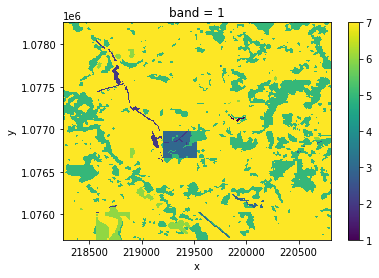

In [13]:
x.isel(band=0).plot()

## Plot consensus value

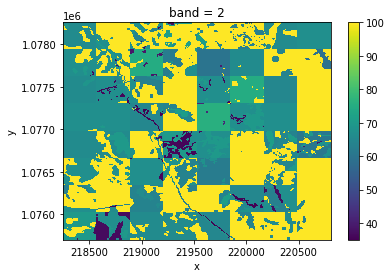

In [15]:
x.isel(band=1).plot()